In [1]:
!pip install labelme tensorflow opencv-python matplotlib albumentations

In [17]:
# Install missing dependency for gensim
!pip install --user FuzzyTM>=0.4.0



In [2]:
# Resolve packaging version conflict for streaml

# Update pip and setuptools
!pip install --upgrade pip setuptools

# Install numpy and matplotlib if needed
!pip install --user numpy matplotlib


The system cannot find the file specified.


In [3]:
import os
import time
import uuid
import cv2
import tensorflow as tf
import json
from matplotlib import pyplot as plt
import numpy as np


In [4]:
IMAGES_PATH = os.path.join('data-images','images')
number_images = 40

In [6]:
for image_num in range(40):
    print(image_num)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


In [7]:
!pip install opencv-python

!pip install --user opencv-contrib-python


In [10]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(0) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()


## Annotate images with LabelMe

In [11]:
!pip install PyQt5

### Step two (Review Dataset and Build image loading function
### limit GPU Memory Growth

In [20]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


In [21]:
tf.config.list_physical_devices('GPU')

[]

In [84]:
from tensorflow import keras
from tensorflow.keras import layers

### load images into TF Data Pipeline

In [22]:
images = tf.data.Dataset.list_files('data-images\\images\\*.jpg', shuffle=False)

In [23]:
images.as_numpy_iterator().next()

b'data-images\\images\\0004206b-36be-11ef-b892-d2db4cd8f7c7.jpg'

In [24]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [25]:
images = images.map(load_image)

In [26]:
images.as_numpy_iterator().next()

array([[[128, 129, 121],
        [128, 129, 121],
        [128, 129, 121],
        ...,
        [207, 207, 197],
        [207, 207, 197],
        [208, 208, 198]],

       [[126, 127, 119],
        [127, 128, 120],
        [127, 128, 120],
        ...,
        [206, 206, 196],
        [207, 207, 197],
        [208, 208, 198]],

       [[128, 129, 121],
        [128, 129, 121],
        [129, 130, 122],
        ...,
        [206, 206, 196],
        [207, 207, 199],
        [207, 207, 199]],

       ...,

       [[ 39,  35,  26],
        [ 42,  38,  29],
        [ 43,  39,  30],
        ...,
        [219, 221, 220],
        [220, 222, 221],
        [221, 223, 222]],

       [[ 38,  34,  25],
        [ 40,  36,  27],
        [ 41,  37,  28],
        ...,
        [220, 222, 221],
        [221, 223, 222],
        [222, 224, 223]],

       [[ 40,  36,  27],
        [ 41,  37,  28],
        [ 42,  38,  29],
        ...,
        [220, 222, 221],
        [219, 221, 220],
        [219, 221, 220]]

### View Raw images with Matplotlib(visualizing our images)

In [32]:
image_generator = images.batch(4).as_numpy_iterator()

In [46]:
plot_images = image_generator.next()

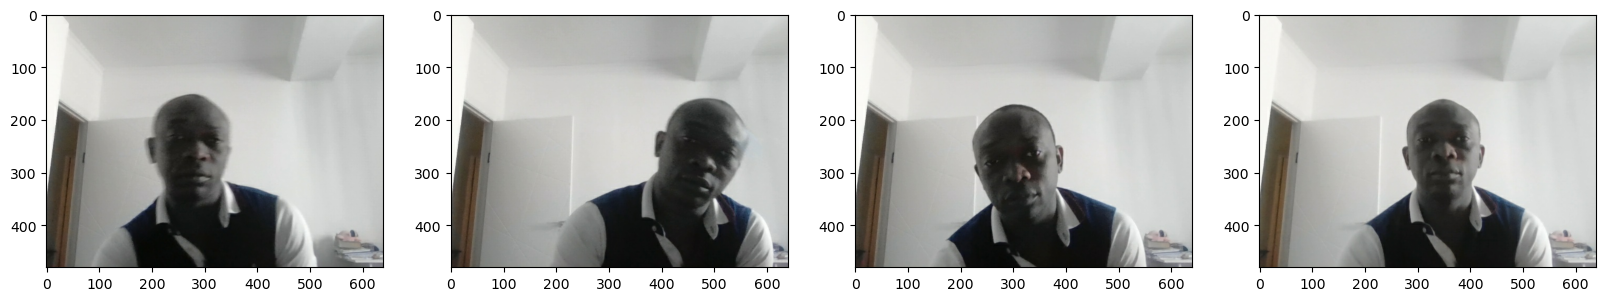

In [47]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()    

## step 3. Partition Unaugumented Data

Found 120 files belonging to 2 classes.


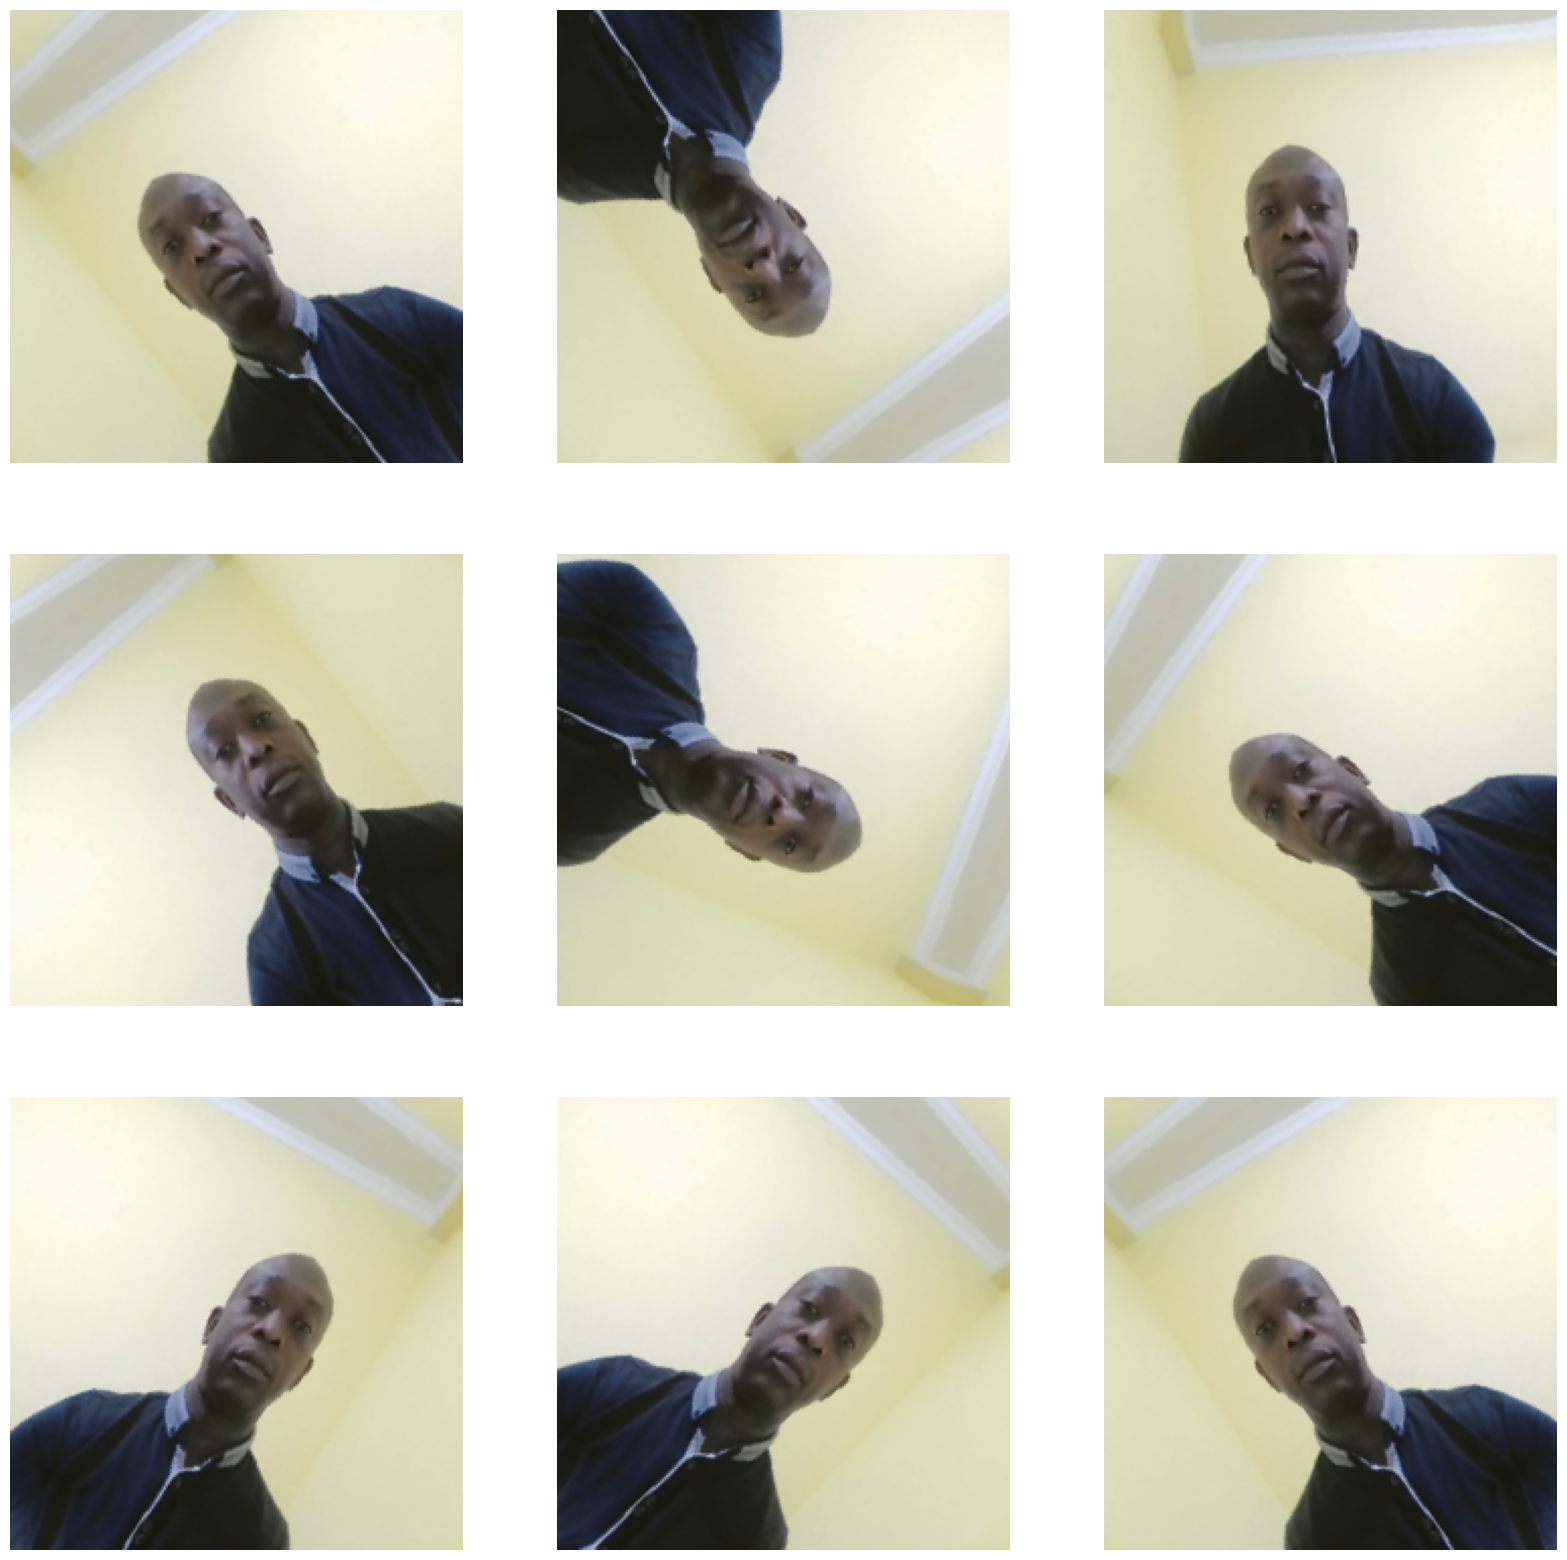

In [86]:
import os
from sklearn.model_selection import train_test_split

# Directory containing images
data_dir = 'data-images'

# Parameters
img_height = 224
img_width = 224
batch_size = 32

# Load images from directory
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='int'
)

# Split the dataset into training, validation, and test sets
def get_dataset_partitions(dataset, train_split=0.8, val_split=0.1, test_split=0.1):
    dataset_size = len(dataset)
    train_size = int(train_split * dataset_size)
    val_size = int(val_split * dataset_size)
    test_size = dataset_size - train_size - val_size

    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size).take(val_size)
    test_dataset = dataset.skip(train_size + val_size)

    return train_dataset, val_dataset, test_dataset
# Split the dataset
train_dataset, val_dataset, test_dataset = get_dataset_partitions(image_dataset)

# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),  
])

# Visualize some images
plt.figure(figsize=(20, 20))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_image = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_image[0].numpy().astype("uint8"))
        plt.axis("off")
plt.show()


In [50]:
# Verify class distribution
class_names = image_dataset.class_names
print("Class names:", class_names)

for images, labels in image_dataset:
    print("Number of images in batch:", len(images))
    unique_labels, counts = np.unique(labels.numpy(), return_counts=True)
    print("Class distribution in this batch:", dict(zip(class_names, counts)))
    break  # Only check the first batch


Class names: ['images', 'labels']
Number of images in batch: 32
Class distribution in this batch: {'images': 32}


In [ ]:
verify the data distribution

Found 120 files belonging to 2 classes.


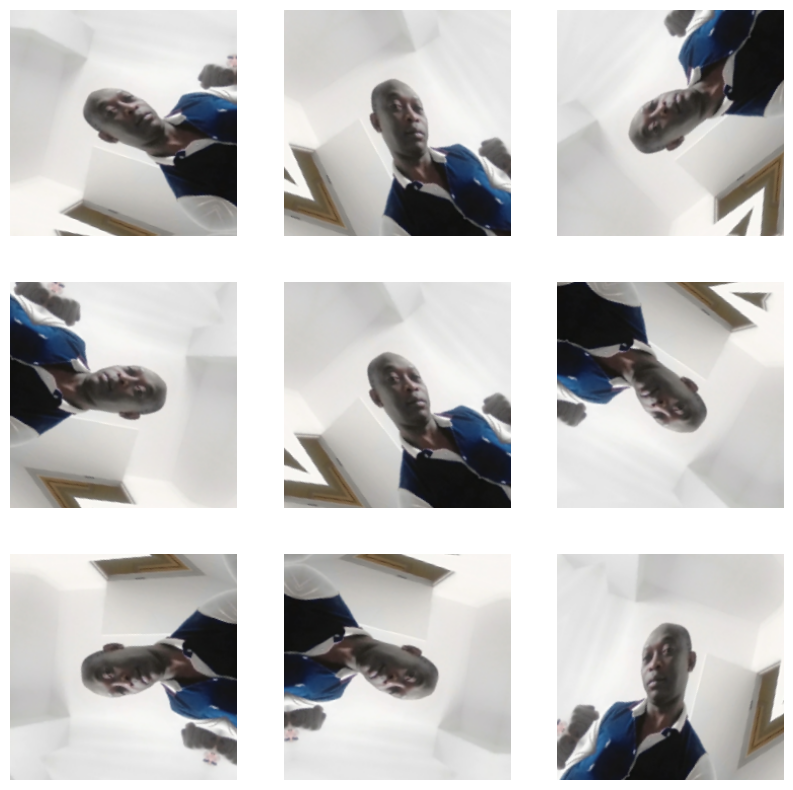

In [59]:
# Directory containing images
data_dir = 'data-images'

# Parameters
img_height = 224
img_width = 224
batch_size = 32

# Load images from directory
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='int'  # Ensure labels are integers
)

# Convert all labels to the same class
image_dataset = image_dataset.map(lambda x, y: (x, tf.zeros_like(y)))

# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),  
])

# Apply data augmentation to the dataset
augmented_dataset = image_dataset.map(lambda x, y: (data_augmentation(x), y))

# Split the dataset into training, validation, and test sets
def get_dataset_partitions(dataset, train_split=0.8, val_split=0.1, test_split=0.1):
    dataset_size = tf.data.experimental.cardinality(dataset).numpy()
    train_size = int(train_split * dataset_size)
    val_size = int(val_split * dataset_size)
    test_size = dataset_size - train_size - val_size

    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size).take(val_size)
    test_dataset = dataset.skip(train_size + val_size)

    return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = get_dataset_partitions(augmented_dataset)

# Visualize some images
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_image = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_image[0].numpy().astype("uint8"))
        plt.axis("off")
plt.show()


In [ ]:
# Build a CNN model

In [61]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Single output for one class
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [62]:
epochs = 50

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs
)

# Evaluate the model
loss, accuracy = model.evaluate(test_dataset)
print(f'Test accuracy: {accuracy * 100:.2f}%')


Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 691ms/step - accuracy: 0.7517 - loss: 1.5348

C:\Users\seasi\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


AttributeError: 'NoneType' object has no attribute 'items'

In [ ]:
alternative approach

In [68]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Single output for one class
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [69]:
epochs = 50
steps_per_epoch = 3  # Number of steps per epoch, should be len(train_dataset) // batch_size
validation_steps = 1  # Number of steps for validation, should be len(val_dataset) // batch_size

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)

# Evaluate the model
loss, accuracy = model.evaluate(test_dataset, steps=validation_steps)
print(f'Test accuracy: {accuracy * 100:.2f}%')


Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - accuracy: 0.9809 - loss: 0.4023

AttributeError: 'NoneType' object has no attribute 'items'

In [81]:
for image, label in train_dataset.take(1):
    print(image.shape, label)
for image, label in val_dataset.take(1):
    print(image.shape, label)
for image, label in test_dataset.take(1):
    print(image.shape, label)


(32, 32, 224, 224, 3) tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(32, 32), dtype=int32)
(24, 224, 224, 3) tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(24,), dtype=int32)
